In [1]:
import pandas as pd
import numpy as np

from plot.multicurve import MultiCurvePlotter
from plot.dual_plot import DualPlot
from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

In [2]:
data_size = 100

In [3]:
# Base Case
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(speed=30.0, phi=0.9)
base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(data_size, energy_uptime=5, energy_io=25)
d_out = obc.process(data_size)

ground_link = TransmissionNode(speed=10.0)
base_time_cost += ground_link.time_cost(d_out)
base_energy_cost += ground_link.energy_cost(d_out, energy=5, distance=700)

In [4]:
# EC Case - Multiple phi values
speeds = np.arange(1, 500, 5)  # Reduced step size for smoother curves
phis = np.arange(0.1, 1.0, 0.2)  # [0.1, 0.3, 0.5, 0.7, 0.9]

print(f"Testing {len(phis)} phi values: {phis}")
print(f"Speed range: {speeds[0]} to {speeds[-1]} Mb/s ({len(speeds)} points)")

# Initialize multi-curve plotters
time_plotter = MultiCurvePlotter(
    title="Time Cost vs ISL Speed for Different Phi Values",
    xlabel="ISL Speed (Mb/s)",
    ylabel="Time (s)"
)

energy_plotter = MultiCurvePlotter(
    title="Energy Cost vs ISL Speed for Different Phi Values",
    xlabel="ISL Speed (Mb/s)",
    ylabel="Energy (J)"
)

# Color palette for different phi values
colors = ['#0000FF', '#4D4DFF', '#8080FF', '#B3B3FF', '#E6E6FF']

time_plotter.add_curve_from_arrays(
    speeds, [base_time_cost] * len(speeds),
    label=f"Base Time Cost: {round(base_time_cost, 3)}",
    color='gold',
    line_width=2.0
)

energy_plotter.add_curve_from_arrays(
    speeds, [base_energy_cost] * len(speeds),
    label=f"Base Energy Cost: {round(base_energy_cost, 3)}",
    color='gold',
    line_width=2.0
)

Testing 5 phi values: [0.1 0.3 0.5 0.7 0.9]
Speed range: 1 to 496 Mb/s (100 points)


In [5]:
# Calculate costs for each phi value
obc = ComputingNode(speed=30.0, phi=0.9)
user_time_cost = obc.time_cost(data_size)
user_energy_cost = obc.energy_cost(data_size, energy_uptime=5, energy_io=25)
d_out_obc = obc.process(data_size)

for i, phi in enumerate(phis):
    print(f"Processing phi = {phi:.1f}")

    time_costs = []
    energy_costs = []

    for speed in speeds:
        # ISL transmission
        isl = TransmissionNode(speed=float(speed))
        iteration_time_cost = isl.time_cost(d_out_obc)
        iteration_energy_cost = isl.energy_cost(d_out_obc, energy=5, distance=100)

        # Edge computing with current phi value
        edge_computer = ComputingNode(speed=300.0, phi=phi)
        iteration_time_cost += edge_computer.time_cost(d_out_obc)
        iteration_energy_cost += edge_computer.energy_cost(d_out_obc, energy_uptime=5, energy_io=25)
        d_out_ec = edge_computer.process(d_out_obc)

        # Ground link transmission
        ground_link = TransmissionNode(speed=10.0)
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(d_out_ec, energy=5, distance=700)

        # Total costs
        total_time = user_time_cost + iteration_time_cost
        total_energy = user_energy_cost + iteration_energy_cost

        time_costs.append(total_time)
        energy_costs.append(total_energy)

    # Add curves to plotters
    time_plotter.add_curve_from_arrays(
        speeds, time_costs,
        label=f"φ = {phi:.1f}",
        color=colors[i % len(colors)],
        line_width=2.0
    )

    energy_plotter.add_curve_from_arrays(
        speeds, energy_costs,
        label=f"φ = {phi:.1f}",
        color=colors[i % len(colors)],
        line_width=2.0
    )

print("Data processing complete!")

Processing phi = 0.1
Processing phi = 0.3
Processing phi = 0.5
Processing phi = 0.7
Processing phi = 0.9
Data processing complete!


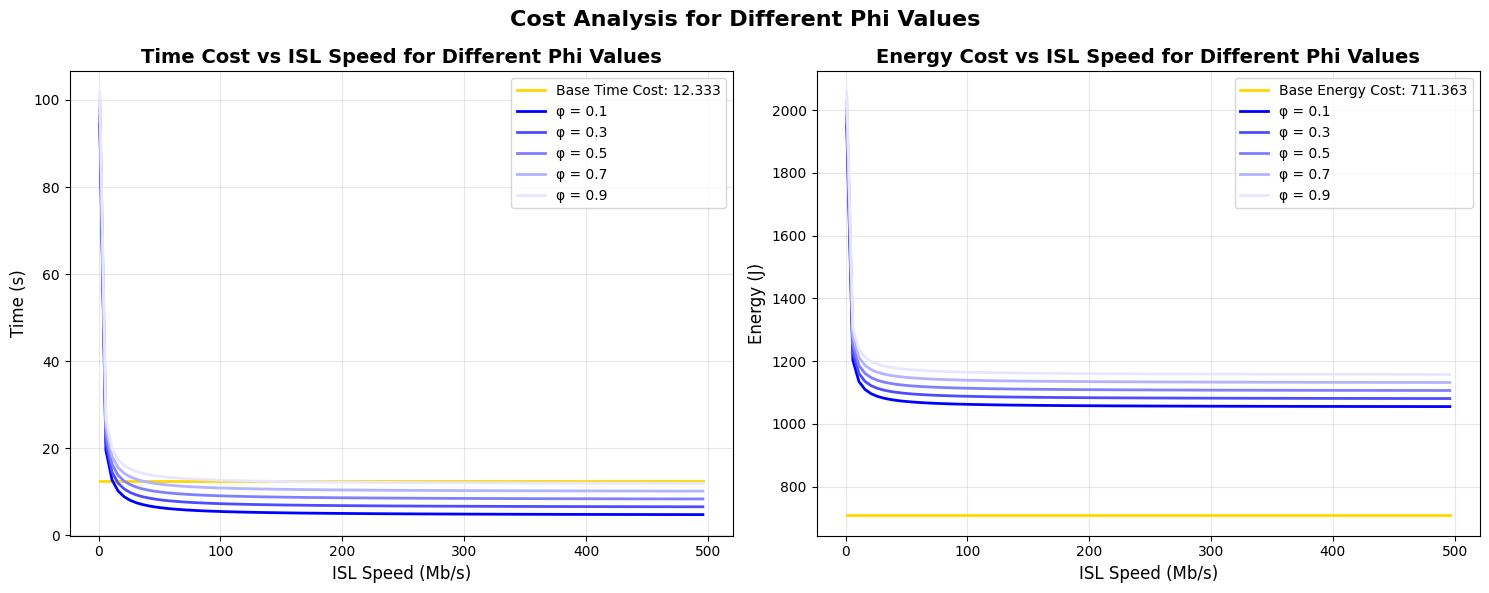

(<Figure size 1500x600 with 2 Axes>,
 (<Axes: title={'center': 'Time Cost vs ISL Speed for Different Phi Values'}, xlabel='ISL Speed (Mb/s)', ylabel='Time (s)'>,
  <Axes: title={'center': 'Energy Cost vs ISL Speed for Different Phi Values'}, xlabel='ISL Speed (Mb/s)', ylabel='Energy (J)'>))

In [6]:
# Display both plots side by side using DualPlot
dual_plot = DualPlot(
    left_plotter=time_plotter,
    right_plotter=energy_plotter,
    figsize=(15, 6),
    main_title="Cost Analysis for Different Phi Values"
)

dual_plot.plot()

# Optionally export the combined plot
# dual_plot.export_png("phi_analysis_combined.png", dpi=300)
# dual_plot.export_latex("phi_analysis_combined.pgf")